In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
df = pd.read_csv('hh_OHE.csv')
df.head()

,link,vacancy,company,city,experience,company_rating,wage_k,full_time,office,distant
0,https://adsrv.hh.ru/click?b=1003372&place=35&m...,Водитель со своим грузовым автомобилем,ИП Петрикин Александр Вячеславович,Москва,0,4.5,180.0,1,1,0
1,https://adsrv.hh.ru/click?b=993174&place=36&me...,Консультант поддержки в Яндекс Путешествия,Яндекс Крауд: Поддержка,Москва,0,4.0,30.0,1,0,0
2,https://hh.ru/vacancy/98672015?hhtmFrom=vacanc...,Менеджер по заполнению анкет (удаленно),ИП Кабин Дмитрий Владимирович,Москва,0,3.5,36.8,1,0,0
3,https://hh.ru/vacancy/98657055?hhtmFrom=vacanc...,Ручной тестировщик (QA Manual Junior),Oxytocin,Москва,0,3.5,60.0,1,1,0
4,https://hh.ru/vacancy/93848299?utm_source=head...,Торговый представитель (Водитель-курьер),ЦУМ,Москва,1,4.0,170.0,1,0,0


Можно приступать к обучению модели! Разделим выборку на обучающую и тестовую.

In [109]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=12)

y_train = df_train['wage_k'].to_numpy()
y_test = df_test['wage_k'].to_numpy()

X_train = df_train[['experience', 'company_rating', 'full_time', 'office', 'distant']].to_numpy()
X_test = df_test[['experience', 'company_rating', 'full_time', 'office', 'distant']].to_numpy()

X_train.shape, X_test.shape

((1453, 5), (624, 5))

Теперь построим наивный прогноз

In [110]:
y_naive = np.ones(len(y_test)) * np.mean(y_train)

Для определения качества мы будем использовать метрику качества __МАЕ__. Этот выбор обусловлен тем, что целевая переменная выражена в тысячах рублей, то есть это реальные значения, а потому важно, чтобы ошибки были в среднем взвешены одинаково. 

In [111]:
mae_naive = mae(y_test, y_naive)
print(f'MAE: {mae_naive}')

MAE: 48.56842790446821


Ну страх, конечно, наивный прогноз ошибается в среднем на почти 48 тысяч рублей. Теперь попробуем обучить модель и, может, станет лучше.

In [112]:
model_regression = LinearRegression()
model = model_regression.fit(X_train, y_train)
model.intercept_, model.coef_

(37.22649894204467,
 array([19.0658404 ,  8.46965278,  7.09978808, 15.97392011, 96.55461119]))

Так, согласно модели, уравнение линейной регрессии для зарпалаты имеет такой вид:                                                                                                 
__Wage = 37.23 + 19.07 * Experience + 8.47 * Company's rating + 7.10 * Full-time job + 15.97 * Office + 96.55 * Distant__

In [113]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [114]:
mae_pred = mae(y_test, y_pred)
print(f'MAE: {mae_pred}')

MAE: 42.45028482431331


Что ж... стало совсем немного лучше, но это уже радует!) Все-таки, как мы и выяснили ранее, среди данных, собранных на hh.ru сложно отследить сильные связи, возмонжо, упускаются какие-то ключевые параметры или предложенные в вакансиях зарплаты не соответствуют ожидаемым при исходных данных.

In [115]:
pd.DataFrame(X_train) #не могли понять, что случилось с названиями столбцов

,0,1,2,3,4
0,1.0,4.2,1.0,0.0,0.0
1,0.0,4.3,1.0,1.0,0.0
2,3.0,3.4,1.0,0.0,1.0
3,0.0,4.5,1.0,0.0,1.0
4,6.0,3.9,1.0,1.0,0.0
...,...,...,...,...,...
1448,1.0,2.0,1.0,1.0,0.0
1449,1.0,4.6,1.0,1.0,0.0
1450,1.0,3.8,1.0,0.0,0.0
1451,0.0,3.9,1.0,1.0,0.0


Проведем кросс-валидацию для оценки точности нашей модели

In [116]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(model, df[['experience', 'company_rating', 'full_time', 'office', 'distant']], df['wage_k'], cv=cv)
scores

array([0.0927955 , 0.19033963, 0.17171654, 0.12744488, 0.209178  ])

In [117]:
print("%0.2f средняя оценка точности со стандартным отклонением %0.2f" % (scores.mean(), scores.std()))

0.16 средняя оценка точности со стандартным отклонением 0.04


Ладно, мы не то чтобы претендовали на гениальную модель, поэтому рады, что accuracy хотя бы не 0!

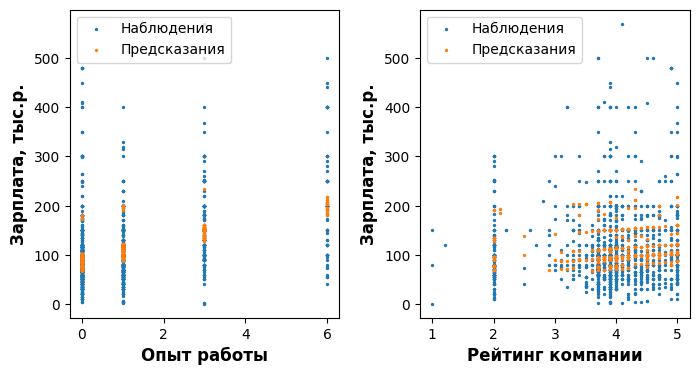

In [118]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
y = ['Опыт работы', 'Рейтинг компании']
y_names = [0, 1]

for i, data, n in zip(ax.flatten(), y_names, y):

    i.scatter(pd.DataFrame(X_train)[data], pd.DataFrame(y_train), s=2)
    # i.set_xticks(np.array(df[data].unique()))
    i.set_xlabel(n, fontsize=12, fontweight='bold')
    i.set_ylabel('Зарплата, тыс.р.', fontsize=12, fontweight='bold')
    i.scatter(pd.DataFrame(X_test)[data],pd.DataFrame(y_pred), s=2)
    i.legend(['Наблюдения', 'Предсказания'])
f.subplots_adjust(wspace=0.3, hspace=0.3)


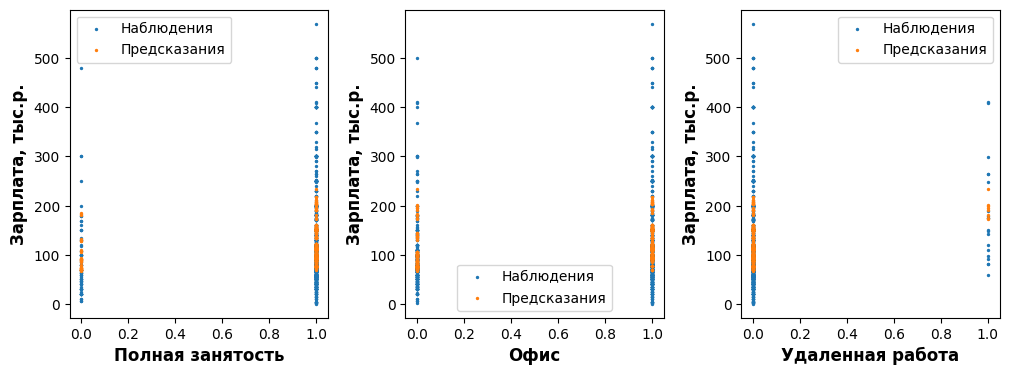

In [119]:
f, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)
y = ['Полная занятость', 'Офис', 'Удаленная работа']
y_names = [2, 3, 4]

for i, data, n in zip(ax.flatten(), y_names, y):

    i.scatter(pd.DataFrame(X_train)[data], pd.DataFrame(y_train), s=2)
    # i.set_xticks(np.array(df[data].unique()))
    i.set_xlabel(n, fontsize=12, fontweight='bold')
    i.set_ylabel('Зарплата, тыс.р.', fontsize=12, fontweight='bold')
    i.scatter(pd.DataFrame(X_test)[data],pd.DataFrame(y_pred), s=2)
    i.legend(['Наблюдения', 'Предсказания'])
f.subplots_adjust(wspace=0.3, hspace=0.3)

In [127]:
def plot_yreal_ypred(y_test, y_train, y_test_hat, y_train_hat):
    """
        Рисует картинку для прогнозов регрессии 
    """
    
    margin = 0.1 # отступ на границах
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_train, y_train_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    train_min = min(y_train)
    train_max = max(y_train)
    plt.xlim(train_min - margin, train_max + margin)
    plt.ylim(train_min - margin, train_max + margin)
    plt.plot([0, 1000], [0, 1000])
    plt.title('Train set', fontsize=20)

    plt.subplot(122)
    plt.scatter(y_test, y_test_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    test_min = min(y_test)
    test_max = max(y_test)
    plt.xlim(test_min - margin, test_max + margin)
    plt.ylim(test_min - margin, test_max + margin)
    plt.plot([0, 1000], [0, 1000])
    plt.title('Test set', fontsize=20)
    pass

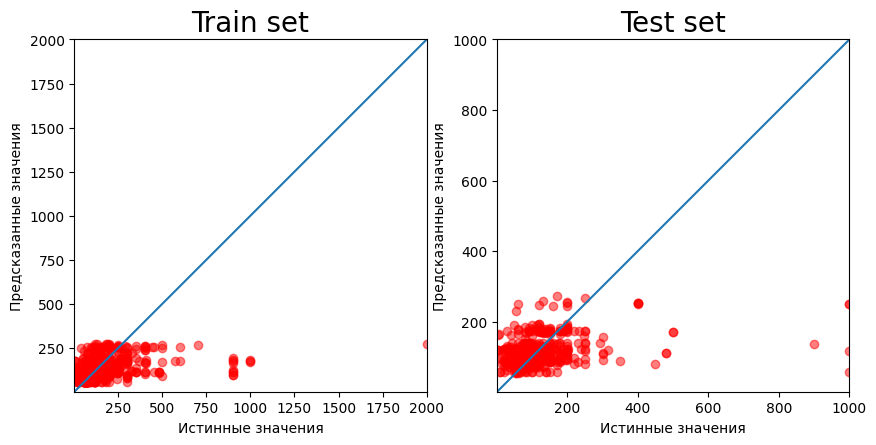

In [79]:
plot_yreal_ypred(y_test, y_train, y_pred, y_pred_train)

Исходя из графиков, наша модель предсказывала более усредненные значения, так как некоторые очень большие зарплаты в выборке действительно превышают ожидаемые при таких харакетристиках работодателя и требованиях к работнику. Возможно, для более точных значений нужна выборка больших размеров с увеличенным количеством признаков.